In [3]:
from scipy.stats import multivariate_normal as mnorm
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import math
from tqdm import tqdm
from scipy.optimize import minimize, basinhopping
import optuna

# Simple Regression Problem

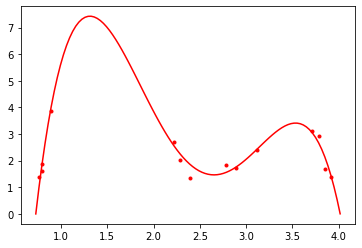

In [20]:
rng = np.random.default_rng(seed=1354)
N = 100
exp_er = 0.2 #10
# def truef(x):
#     return x**2+1
def truef(x):
    a,b,c,d,e,f = -1.6,1.8,-6,0,2.4,2.5
    return -(e*(x-f)**4+d*(x-f)**3+c*(x-f)**2+b*(x-f)+a)
x = np.linspace(0.729,4.015,N) #(1,10,10)
y = truef(x)
xd_indicies = [int(1/(N/100)),int(2/(N/100)),int(2.5/(N/100)),int(5/(N/100)),int(45/(N/100)),int(47/(N/100)),int(50/(N/100)),int(62/(N/100)),int(65/(N/100)),int(72/(N/100)),int(90/(N/100)),int(92/(N/100)),int(94/(N/100)),int(96/(N/100))]
# xd_indicies = np.linspace(0,N-1,20).astype(int)
# xd_indicies = range(N)
xd = x[xd_indicies]
M = len(xd)
yd = rng.normal(loc=truef(xd),scale=exp_er)

figSRP = plt.figure()
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
plt.show()

prior_mean_vector = np.repeat(4,N)

# Gaussian Process Regression 3
See notes, uses bayes theorum and the prediction can have many x values. Also applicable to interferometry. 



Not good if zero, as need to be inverted.
The Determinent of K is: 2.6518256287550655e+95
The Determinent of cov_li is: 1.6069380442588865e-40
The Determinent of cov_post3 is: 4.814975588422063e+41


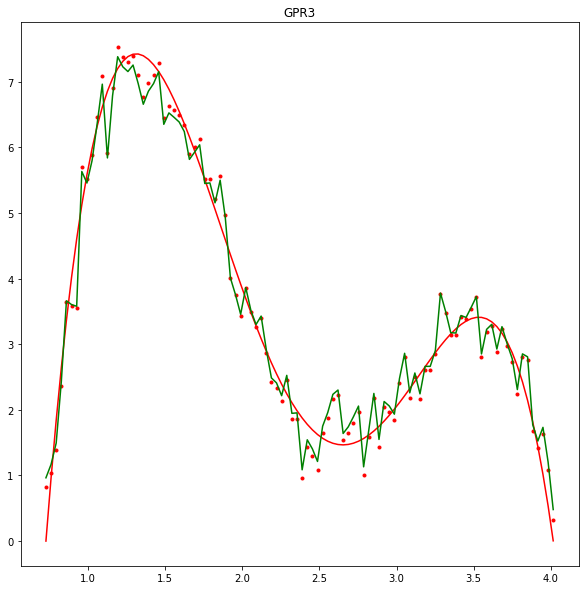

In [29]:
##Prior
mu_prior = prior_mean_vector
#exponential square kernel
def Kernel(x1,x2,params):
    #amplitude determins how far the model can go from the mean
    amp = params[0]
    #length scale determines smoothness, how correlated the function should be at a distance
    l = params[1]
    return amp**2 * np.exp(-((x1-x2)*(x1-x2))/(2*l**2))

def KRcov_li(params,trial_exp_er):
    X1, X2 = np.meshgrid(x,x)
    #covergence matrix of Prior
    K = Kernel(X1,X2,params)
    #covergence matrix of Likelyhood
    cov_li = np.diag(np.repeat(trial_exp_er,len(xd)))
    #R is a matrix that can take a potential function vector f_N and only return M values corresponding to f(x_1)...f(x_M) 
    R = np.zeros((M,N))
    for i in range(M):
        R[i,xd_indicies[i]]=1
    return K, R, cov_li


def MargLi(params):
    amp=params[0]
    l = params[1]
    K, R, cov_li = KRcov_li(amp,l,exp_er)
    # we want to find the parameters that min this
    return 0.5*np.log(np.linalg.det(cov_li + R@K@R.T)) + 0.5*(yd.T@inv(cov_li+R@K@R.T)@yd)                
    
x0=[3,0.01]
# results = minimize(MargLi2, x0=x0)
# results = basinhopping(MargLi2, x0=x0, niter=100)
# print(results)
best_params = results.x
# best_params = x0

#little data
# best_params = (7.4,0.7)
# print('margi LI',MargLi(*best_params,exp_er))

# print('best Params',best_params)
# print('loggli',best_margli)


def PlotBest(amp,l,trial_exp_er): 
    K, R, cov_li = KRcov_li(amp,l,trial_exp_er)
    cov_post3 = R.T @ inv(cov_li) @ R + inv(K)
    mu_post3 = mu_prior + np.linalg.inv(cov_post3) @ R.T @ inv(cov_li) @ (yd - R @ mu_prior)
    error_bars3 = np.diagonal(cov_post3)


    print('\n\nNot good if zero, as need to be inverted.')
    print('The Determinent of K is:', np.linalg.det(K))
    print('The Determinent of cov_li is:', np.linalg.det(cov_li))
    print('The Determinent of cov_post3 is:', np.linalg.det(cov_post3))

    figGPR3 = plt.figure(figsize=(10,10))
    plt.title('GPR3')
    plt.plot(x,y,'r')
    plt.plot(xd,yd,'r.')
    plt.plot(x,mu_post3,'g')
    
#     plt.errorbar(x, mu_post3, yerr=error_bars3)
    plt.show()

PlotBest(*best_params, exp_er)


In [93]:
import optuna

def objective(trial):
    amp = trial.suggest_float('amp', 5, 22)
    l = trial.suggest_float('l', 0, 4)
    return MargLi(amp,l,exp_er)
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

study.best_params

[I 2023-07-20 13:10:04,977] A new study created in memory with name: no-name-31f6b65e-f6ea-46b8-a604-d294f0046786
[I 2023-07-20 13:10:05,007] Trial 0 finished with value: -42.64300644179814 and parameters: {'amp': 11.106946752968422, 'l': 0.2508917554014216}. Best is trial 0 with value: -42.64300644179814.
[I 2023-07-20 13:10:05,019] Trial 1 finished with value: -68.0733359440103 and parameters: {'amp': 21.211870352990452, 'l': 1.5857152431191244}. Best is trial 1 with value: -68.0733359440103.
[I 2023-07-20 13:10:05,030] Trial 2 finished with value: -57.48157069641109 and parameters: {'amp': 11.841339646488539, 'l': 0.3564844942463461}. Best is trial 1 with value: -68.0733359440103.
[I 2023-07-20 13:10:05,040] Trial 3 finished with value: -61.56955556266895 and parameters: {'amp': 21.25767822636175, 'l': 1.7451474559643119}. Best is trial 1 with value: -68.0733359440103.
[I 2023-07-20 13:10:05,061] Trial 4 finished with value: 26.549963054798 and parameters: {'amp': 13.8362794347547, 

[I 2023-07-20 13:10:06,368] Trial 42 finished with value: -76.20821885453645 and parameters: {'amp': 9.71037181274771, 'l': 0.8907717719019239}. Best is trial 37 with value: -76.68548690580343.
[I 2023-07-20 13:10:06,406] Trial 43 finished with value: -69.76811912750269 and parameters: {'amp': 12.172485124767004, 'l': 1.195424408288841}. Best is trial 37 with value: -76.68548690580343.
[I 2023-07-20 13:10:06,446] Trial 44 finished with value: -61.00630380263873 and parameters: {'amp': 13.123939889123406, 'l': 1.4735429262912603}. Best is trial 37 with value: -76.68548690580343.
[I 2023-07-20 13:10:06,485] Trial 45 finished with value: -76.48972701793163 and parameters: {'amp': 11.640879197369365, 'l': 0.9394415789646675}. Best is trial 37 with value: -76.68548690580343.
[I 2023-07-20 13:10:06,524] Trial 46 finished with value: -69.34457062129934 and parameters: {'amp': 11.669710359460385, 'l': 1.1873486450920483}. Best is trial 37 with value: -76.68548690580343.
[I 2023-07-20 13:10:06,

[I 2023-07-20 13:10:08,107] Trial 84 finished with value: -72.63555077191796 and parameters: {'amp': 17.956418811318503, 'l': 1.279476480452976}. Best is trial 79 with value: -76.87859440480236.
[I 2023-07-20 13:10:08,157] Trial 85 finished with value: -74.91191659125971 and parameters: {'amp': 19.186927301359727, 'l': 0.8259542526848973}. Best is trial 79 with value: -76.87859440480236.
[I 2023-07-20 13:10:08,202] Trial 86 finished with value: -72.80392435517376 and parameters: {'amp': 18.414307570998282, 'l': 0.7040807347490039}. Best is trial 79 with value: -76.87859440480236.
[I 2023-07-20 13:10:08,248] Trial 87 finished with value: -69.96988513532337 and parameters: {'amp': 20.214460665338784, 'l': 1.4666749458062147}. Best is trial 79 with value: -76.87859440480236.
[I 2023-07-20 13:10:08,289] Trial 88 finished with value: -76.80090932165797 and parameters: {'amp': 17.074920681701684, 'l': 1.036991991281781}. Best is trial 79 with value: -76.87859440480236.
[I 2023-07-20 13:10:08

[I 2023-07-20 13:10:09,839] Trial 126 finished with value: -72.5175003121176 and parameters: {'amp': 19.588909313328607, 'l': 1.3250719704340224}. Best is trial 79 with value: -76.87859440480236.
[I 2023-07-20 13:10:09,884] Trial 127 finished with value: -76.71819929345945 and parameters: {'amp': 19.004583876496227, 'l': 1.0833957658891777}. Best is trial 79 with value: -76.87859440480236.
[I 2023-07-20 13:10:09,926] Trial 128 finished with value: -64.41275345496284 and parameters: {'amp': 18.27324434637639, 'l': 0.507310131362926}. Best is trial 79 with value: -76.87859440480236.
[I 2023-07-20 13:10:09,967] Trial 129 finished with value: -73.81226837045529 and parameters: {'amp': 17.576432506642384, 'l': 1.2244890201221397}. Best is trial 79 with value: -76.87859440480236.
[I 2023-07-20 13:10:10,010] Trial 130 finished with value: -76.2625161914259 and parameters: {'amp': 16.801426073905894, 'l': 0.896598557519853}. Best is trial 79 with value: -76.87859440480236.
[I 2023-07-20 13:10:

[I 2023-07-20 13:10:11,650] Trial 168 finished with value: -75.02963001405249 and parameters: {'amp': 17.54310344794776, 'l': 0.8039405520494871}. Best is trial 79 with value: -76.87859440480236.
[I 2023-07-20 13:10:11,694] Trial 169 finished with value: -76.50423714311967 and parameters: {'amp': 19.4623425293757, 'l': 1.115835993846098}. Best is trial 79 with value: -76.87859440480236.
[I 2023-07-20 13:10:11,737] Trial 170 finished with value: 27.85239116018346 and parameters: {'amp': 19.119592486886415, 'l': 2.1966613212927584}. Best is trial 79 with value: -76.87859440480236.
[I 2023-07-20 13:10:11,782] Trial 171 finished with value: -76.87532628874696 and parameters: {'amp': 17.907812887592495, 'l': 1.0100218714458478}. Best is trial 79 with value: -76.87859440480236.
[I 2023-07-20 13:10:11,828] Trial 172 finished with value: -76.80731826372343 and parameters: {'amp': 18.486048874876396, 'l': 1.059670549255169}. Best is trial 79 with value: -76.87859440480236.
[I 2023-07-20 13:10:1

[I 2023-07-20 13:10:13,555] Trial 210 finished with value: -74.31673539882705 and parameters: {'amp': 17.439741186892913, 'l': 0.7561525091841573}. Best is trial 198 with value: -76.8798724870611.
[I 2023-07-20 13:10:13,598] Trial 211 finished with value: -76.8297287428339 and parameters: {'amp': 18.192184076848363, 'l': 0.99538173162603}. Best is trial 198 with value: -76.8798724870611.
[I 2023-07-20 13:10:13,644] Trial 212 finished with value: -76.8535362449393 and parameters: {'amp': 18.221004793028516, 'l': 1.0034234014617691}. Best is trial 198 with value: -76.8798724870611.
[I 2023-07-20 13:10:13,691] Trial 213 finished with value: -76.8460051674636 and parameters: {'amp': 18.706410065746304, 'l': 1.0528112444068978}. Best is trial 198 with value: -76.8798724870611.
[I 2023-07-20 13:10:13,737] Trial 214 finished with value: -75.92120073627937 and parameters: {'amp': 18.26239117962537, 'l': 1.139898783721871}. Best is trial 198 with value: -76.8798724870611.
[I 2023-07-20 13:10:13

[I 2023-07-20 13:10:15,560] Trial 252 finished with value: -76.87029189751861 and parameters: {'amp': 17.944473884548014, 'l': 1.03090581290907}. Best is trial 198 with value: -76.8798724870611.
[I 2023-07-20 13:10:15,609] Trial 253 finished with value: -75.53422885466203 and parameters: {'amp': 18.02035100079864, 'l': 1.1573530948912467}. Best is trial 198 with value: -76.8798724870611.
[I 2023-07-20 13:10:15,659] Trial 254 finished with value: -76.5160847933756 and parameters: {'amp': 11.279745010627257, 'l': 0.9199873567076722}. Best is trial 198 with value: -76.8798724870611.
[I 2023-07-20 13:10:15,710] Trial 255 finished with value: -76.84761736563105 and parameters: {'amp': 19.834531754750248, 'l': 1.0285526466296597}. Best is trial 198 with value: -76.8798724870611.
[I 2023-07-20 13:10:15,759] Trial 256 finished with value: -75.74921251524427 and parameters: {'amp': 17.845239723482738, 'l': 0.8674559909081518}. Best is trial 198 with value: -76.8798724870611.
[I 2023-07-20 13:10

[I 2023-07-20 13:10:17,713] Trial 294 finished with value: -76.31568640156306 and parameters: {'amp': 10.024751260194698, 'l': 0.7701603851685727}. Best is trial 283 with value: -76.88005899690431.
[I 2023-07-20 13:10:17,767] Trial 295 finished with value: -76.09577743276827 and parameters: {'amp': 12.323847595494811, 'l': 0.9967472780785546}. Best is trial 283 with value: -76.88005899690431.
[I 2023-07-20 13:10:17,819] Trial 296 finished with value: -76.74739194761736 and parameters: {'amp': 17.873123897243904, 'l': 1.060825382712404}. Best is trial 283 with value: -76.88005899690431.
[I 2023-07-20 13:10:17,873] Trial 297 finished with value: -76.1563419577874 and parameters: {'amp': 18.707328527602982, 'l': 0.9175191516298519}. Best is trial 283 with value: -76.88005899690431.
[I 2023-07-20 13:10:17,927] Trial 298 finished with value: -64.59697179246199 and parameters: {'amp': 8.571455885684056, 'l': 1.1477061932243282}. Best is trial 283 with value: -76.88005899690431.
[I 2023-07-20

[I 2023-07-20 13:10:19,975] Trial 336 finished with value: -68.51229532087008 and parameters: {'amp': 16.645796279091158, 'l': 1.4032279538140098}. Best is trial 283 with value: -76.88005899690431.
[I 2023-07-20 13:10:20,029] Trial 337 finished with value: 663.3980191732796 and parameters: {'amp': 19.439536562816038, 'l': 3.3998159184768095}. Best is trial 283 with value: -76.88005899690431.
[I 2023-07-20 13:10:20,083] Trial 338 finished with value: -75.26469873117152 and parameters: {'amp': 17.25365462350123, 'l': 1.1558068101024337}. Best is trial 283 with value: -76.88005899690431.
[I 2023-07-20 13:10:20,138] Trial 339 finished with value: -64.19848705190734 and parameters: {'amp': 17.731667449505597, 'l': 1.5866132928518273}. Best is trial 283 with value: -76.88005899690431.
[I 2023-07-20 13:10:20,191] Trial 340 finished with value: -76.88013252940306 and parameters: {'amp': 18.20582351286523, 'l': 1.0249274548060212}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20

[I 2023-07-20 13:10:22,282] Trial 378 finished with value: -73.23407095434301 and parameters: {'amp': 17.46497508968841, 'l': 0.7059836663756829}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:22,340] Trial 379 finished with value: -76.86017697455739 and parameters: {'amp': 18.606256553614347, 'l': 1.0461144704444472}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:22,396] Trial 380 finished with value: -75.85581559598434 and parameters: {'amp': 18.286352572748203, 'l': 0.8841954612724362}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:22,452] Trial 381 finished with value: -72.49777263492993 and parameters: {'amp': 12.164939784208967, 'l': 1.1242935483531464}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:22,508] Trial 382 finished with value: -69.55498170180675 and parameters: {'amp': 19.90052767194358, 'l': 1.4765296190704529}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-2

[I 2023-07-20 13:10:24,697] Trial 420 finished with value: -61.66851920351448 and parameters: {'amp': 19.08513425473884, 'l': 0.47438426838569847}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:24,756] Trial 421 finished with value: -76.32613089474414 and parameters: {'amp': 18.223266444684068, 'l': 0.9260301874571042}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:24,814] Trial 422 finished with value: -30.89654654017029 and parameters: {'amp': 16.965600686075284, 'l': 1.897727096284582}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:24,871] Trial 423 finished with value: -75.33264558175978 and parameters: {'amp': 17.43812544586045, 'l': 1.1562344041651758}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:24,929] Trial 424 finished with value: -73.76827651379796 and parameters: {'amp': 19.69569834695542, 'l': 0.7656260467981981}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20

[I 2023-07-20 13:10:27,202] Trial 462 finished with value: -75.85505976568618 and parameters: {'amp': 20.28998738897472, 'l': 1.1788980306049235}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:27,264] Trial 463 finished with value: -75.55365064038699 and parameters: {'amp': 20.481600136480818, 'l': 0.8954772695793569}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:27,323] Trial 464 finished with value: 208.1521873604131 and parameters: {'amp': 13.32346175880797, 'l': 2.341394328778153}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:27,380] Trial 465 finished with value: -64.16954907408268 and parameters: {'amp': 21.67789886251859, 'l': 1.7078763053752333}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:27,438] Trial 466 finished with value: -49.90985959379182 and parameters: {'amp': 19.320118491300246, 'l': 1.833510072236249}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13

[I 2023-07-20 13:10:29,761] Trial 504 finished with value: -71.42531994717324 and parameters: {'amp': 20.62390556715717, 'l': 1.4045720848503094}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:29,824] Trial 505 finished with value: -74.34101577123009 and parameters: {'amp': 18.449253591086084, 'l': 0.7757081860409292}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:29,889] Trial 506 finished with value: -76.79207197844623 and parameters: {'amp': 21.45986927323623, 'l': 1.0401597066998556}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:29,953] Trial 507 finished with value: -75.27075199321402 and parameters: {'amp': 16.630836686251097, 'l': 1.142706675826661}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:30,015] Trial 508 finished with value: -12.747199958561154 and parameters: {'amp': 10.756668645092816, 'l': 1.7448910097239225}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-2

[I 2023-07-20 13:10:32,400] Trial 546 finished with value: -76.7208453799073 and parameters: {'amp': 17.50897385381108, 'l': 0.9627486208718304}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:32,463] Trial 547 finished with value: -73.88611629956436 and parameters: {'amp': 20.1938319147406, 'l': 0.7797053145224059}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:32,527] Trial 548 finished with value: -76.14807658571674 and parameters: {'amp': 15.778626315928815, 'l': 1.077494485499391}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:32,590] Trial 549 finished with value: -70.04127345817903 and parameters: {'amp': 17.997045518351236, 'l': 1.3877835686807336}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:32,656] Trial 550 finished with value: -71.4641884744117 and parameters: {'amp': 18.973620593628542, 'l': 0.667258168520288}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:

[I 2023-07-20 13:10:35,093] Trial 588 finished with value: -76.44622083863821 and parameters: {'amp': 19.988868395913038, 'l': 1.1294839573608242}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:35,156] Trial 589 finished with value: -76.4659559024038 and parameters: {'amp': 19.07018535094263, 'l': 0.9537197264546905}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:35,223] Trial 590 finished with value: -52.10962954482687 and parameters: {'amp': 18.685577420273766, 'l': 1.7942072833401348}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:35,287] Trial 591 finished with value: -76.7878594328862 and parameters: {'amp': 18.27028371637555, 'l': 1.0602757693387057}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:35,351] Trial 592 finished with value: -33.6153267309912 and parameters: {'amp': 21.93176819374579, 'l': 0.27252657515763}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:1

[I 2023-07-20 13:10:37,887] Trial 630 finished with value: 803.301682712173 and parameters: {'amp': 20.834487364511553, 'l': 3.987928101593744}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:37,952] Trial 631 finished with value: -75.39374993979588 and parameters: {'amp': 18.02139642927969, 'l': 0.8411609939826268}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:38,020] Trial 632 finished with value: -76.20904377218335 and parameters: {'amp': 11.569334221312685, 'l': 0.9655196384936735}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:38,087] Trial 633 finished with value: 530.7376138243487 and parameters: {'amp': 16.081089685626623, 'l': 2.9624073034211724}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:38,155] Trial 634 finished with value: -60.36140803700608 and parameters: {'amp': 7.245634881128874, 'l': 1.1406159356053869}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13

[I 2023-07-20 13:10:40,844] Trial 672 finished with value: 241.15812570862965 and parameters: {'amp': 17.80803345186381, 'l': 2.5807210441730852}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:40,917] Trial 673 finished with value: -75.85394280979037 and parameters: {'amp': 18.82018434962529, 'l': 1.1539729372511158}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:40,988] Trial 674 finished with value: -76.87646276102127 and parameters: {'amp': 17.13601912500659, 'l': 1.0042533302271228}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:41,057] Trial 675 finished with value: 720.5169267938364 and parameters: {'amp': 17.18659358108156, 'l': 3.4551606974472473}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:41,128] Trial 676 finished with value: -76.77408311585403 and parameters: {'amp': 16.680572662630347, 'l': 0.9600344913959756}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 1

[I 2023-07-20 13:10:43,885] Trial 714 finished with value: -42.33471038365787 and parameters: {'amp': 16.407732268474863, 'l': 0.2875441371151828}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:43,961] Trial 715 finished with value: -71.0253948931995 and parameters: {'amp': 18.6328293475175, 'l': 1.3646903120091363}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:44,034] Trial 716 finished with value: -76.4998642910367 and parameters: {'amp': 18.17067037036818, 'l': 1.0953137441096685}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:44,109] Trial 717 finished with value: -75.77890667191639 and parameters: {'amp': 8.601802240670919, 'l': 0.8763486914679784}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:44,181] Trial 718 finished with value: -76.84044081061043 and parameters: {'amp': 19.8847746581889, 'l': 1.0267369031961888}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:1

[I 2023-07-20 13:10:47,062] Trial 756 finished with value: -71.2388550884064 and parameters: {'amp': 18.66605512626802, 'l': 0.6565306841141253}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:47,137] Trial 757 finished with value: -76.52294176231423 and parameters: {'amp': 19.895135051835535, 'l': 0.9727326305269426}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:47,210] Trial 758 finished with value: -76.26896874285221 and parameters: {'amp': 16.137006179691657, 'l': 0.8859852963898878}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:47,288] Trial 759 finished with value: -75.15775012502054 and parameters: {'amp': 16.883943595614323, 'l': 0.8004816272246406}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:47,365] Trial 760 finished with value: 450.25184538366835 and parameters: {'amp': 17.63338275798532, 'l': 2.897260287073857}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 

[I 2023-07-20 13:10:50,381] Trial 798 finished with value: 753.8456287900649 and parameters: {'amp': 18.874125585906675, 'l': 3.660362718073877}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:50,469] Trial 799 finished with value: -49.71695771168618 and parameters: {'amp': 19.470344414546503, 'l': 1.8395002041164783}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:50,551] Trial 800 finished with value: -73.95275893451637 and parameters: {'amp': 18.71426863006084, 'l': 0.7589620243779145}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:50,631] Trial 801 finished with value: -57.42737772665263 and parameters: {'amp': 7.139726075120344, 'l': 1.1809227920547265}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:50,713] Trial 802 finished with value: 12.05554895498922 and parameters: {'amp': 19.037600541535376, 'l': 2.1441218145690994}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 1

[I 2023-07-20 13:10:53,807] Trial 840 finished with value: -64.7275293221602 and parameters: {'amp': 19.450197261029242, 'l': 1.6304816577707}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:53,890] Trial 841 finished with value: 120.87387026481915 and parameters: {'amp': 14.54517543988678, 'l': 2.2486210178513986}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:53,977] Trial 842 finished with value: -55.49642653751083 and parameters: {'amp': 19.026203753207643, 'l': 1.767455856140542}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:54,062] Trial 843 finished with value: 736.157924987694 and parameters: {'amp': 16.36146098235006, 'l': 3.462058733035492}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:54,148] Trial 844 finished with value: -76.09678602690332 and parameters: {'amp': 18.599716730193162, 'l': 0.9104109923782475}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:

[I 2023-07-20 13:10:57,606] Trial 882 finished with value: -74.42827885555857 and parameters: {'amp': 17.711901071757882, 'l': 1.2024319325655597}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:57,697] Trial 883 finished with value: 680.4720361956834 and parameters: {'amp': 13.383641592341295, 'l': 3.1267701935141767}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:57,781] Trial 884 finished with value: -76.3952844370537 and parameters: {'amp': 18.329862487726498, 'l': 1.1073943188697248}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:57,871] Trial 885 finished with value: -75.60924016456529 and parameters: {'amp': 17.03272872859703, 'l': 0.8404494542602181}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:10:57,960] Trial 886 finished with value: -76.86218622879544 and parameters: {'amp': 16.24181461542823, 'l': 0.9982204116782664}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 

[I 2023-07-20 13:11:01,176] Trial 924 finished with value: -51.8928070727474 and parameters: {'amp': 7.271551966864936, 'l': 1.2783505998564366}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:11:01,259] Trial 925 finished with value: 469.7237309955456 and parameters: {'amp': 19.54841833768173, 'l': 3.0083067868277635}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:11:01,342] Trial 926 finished with value: -75.91666693219614 and parameters: {'amp': 17.179526167582587, 'l': 1.1199624107681299}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:11:01,425] Trial 927 finished with value: 45.90662864460565 and parameters: {'amp': 18.85562950201352, 'l': 0.10772884342806943}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:11:01,512] Trial 928 finished with value: -76.23463638903954 and parameters: {'amp': 9.317590070871848, 'l': 0.8633154263321512}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13

[I 2023-07-20 13:11:04,793] Trial 966 finished with value: 83.439713661668 and parameters: {'amp': 8.929757274929695, 'l': 1.9041625541919527}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:11:04,879] Trial 967 finished with value: -76.40387683574629 and parameters: {'amp': 18.289150742734435, 'l': 0.9349990087950948}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:11:04,964] Trial 968 finished with value: -76.56522616805672 and parameters: {'amp': 21.72919172715615, 'l': 1.0056426382984065}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:11:05,049] Trial 969 finished with value: -75.99202121344659 and parameters: {'amp': 16.59461552431646, 'l': 1.1039780588530865}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13:11:05,135] Trial 970 finished with value: -75.09053395665036 and parameters: {'amp': 19.090113628899537, 'l': 0.8371767482233519}. Best is trial 340 with value: -76.88013252940306.
[I 2023-07-20 13

{'amp': 18.20582351286523, 'l': 1.0249274548060212}

In [79]:
results

      fun: 4.71578696020939
 hess_inv: array([[1.60813141e-05, 1.44127841e-06],
       [1.44127841e-06, 1.29320615e-07]])
      jac: array([1.75833702e-05, 4.41074371e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 222
      nit: 17
     njev: 70
   status: 2
  success: False
        x: array([7.35781514, 0.73227267])

In [59]:
results

                        fun: 23541.30342439663
 lowest_optimization_result:       fun: 23541.30342439663
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ -2.70092773, 253.48242188])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 25
      nit: 0
     njev: 5
   status: 2
  success: False
        x: array([1010.80415426,   37.2600445 ])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 501
                       nfev: 11076
                        nit: 500
                       njev: 2962
                          x: array([1010.80415426,   37.2600445 ])

# Gaussian Processes 1

This way assumes the data and predictions come from a large multivariate distribution and then uses conditional theorums to find the posterior.



RESULTS                         fun: 7.886163231108369
 lowest_optimization_result:       fun: 7.886163231108369
 hess_inv: array([[3.92224785, 0.28017259],
       [0.28017259, 0.05108583]])
      jac: array([ 2.44379044e-06, -1.19209290e-07])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([4.19101696, 0.59371361])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 1
                       nfev: 6684
                        nit: 200
                       njev: 2224
                          x: array([4.19101696, 0.59371361])


MargLi 7.886163231108369
Probably not good if 0. cov_D definetly cannot be 0 as it is inverted.
The Determinent of K is: 0.0


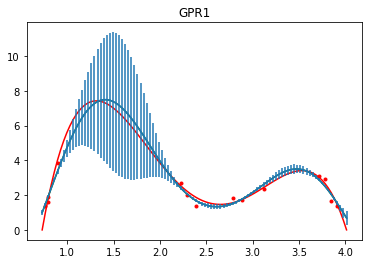

In [19]:
#KERNEL: exponential square kernel
def kernel(x1,x2,params):
    amp = params[0]
    'How far should be between x1 and x2 for f(x1) to be uncorrelated with f(x2)'
    l = params[1]
    return amp**2 * np.exp(-((x1-x2)*(x1-x2))/(2*l**2))
X1, X2 = np.meshgrid(xd,xd)
X1st, X2st = np.meshgrid(x,x)
X1st2, X22 = np.meshgrid(x,xd)

#optimising kernel paramaters via marginal likelyhood
def MargLi(params):
    cov_D = kernel(X1,X2,params) + np.diag(np.repeat(exp_er,len(xd)))
    # we want to find the parameters that min this
    return 0.5 * yd.T@inv(cov_D)@yd + 0.5 * np.log(np.linalg.det(cov_D))

x0=[5,0.1]
# results = minimize(MargLi, x0=x0)
results = basinhopping(MargLi, x0=x0, niter=200)
print('\n\nRESULTS',results)
best_params = results.x

print('\n\nMargLi',MargLi(best_params))

K = kernel(X1,X2,best_params)
Kstst = kernel(X1st, X2st,best_params)
Kst = kernel(X22, X1st2,best_params)
##Data Dist, has prior in it
mu_D = prior_mean_vector
cov_D = K + np.diag(np.repeat(exp_er,len(xd)))


print('Probably not good if 0. cov_D definetly cannot be 0 as it is inverted.')
print('The Determinent of K is:', np.linalg.det(K))
# print('The Determinent of Kst is:', np.linalg.det(Kst))
# print('The Determinent of Kstst is:', np.linalg.det(Kstst))
# print('The Determinent of cov_D is:', np.linalg.det(cov_D))
##Predictions dist
mu_yst = np.repeat(0,N)
cov_yst = Kstst



cov_post1 = Kstst - Kst.T @ np.linalg.inv(cov_D) @ Kst
mu_post1 = Kst.T @ np.linalg.inv(cov_D) @ yd
error_bars1 = np.diagonal(cov_post1)


figGPR1 = plt.figure()
plt.title('GPR1')
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
plt.plot(x,mu_post1,'g')
plt.errorbar(x, mu_post1, yerr=error_bars1)
plt.show()

In [16]:
import optuna

def objective(trial):
    amp = trial.suggest_float('amp', 0, 22)
    l = trial.suggest_float('l', 0, 4)
    params = [amp,l]
    return MargLi(params)
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

study.best_params

[I 2023-07-21 14:21:27,423] A new study created in memory with name: no-name-6615f39f-e48e-46dd-a221-298f3ca83c33
[I 2023-07-21 14:21:27,434] Trial 0 finished with value: 15.76868688230646 and parameters: {'amp': 20.10562109090126, 'l': 1.7660541398143468}. Best is trial 0 with value: 15.76868688230646.
[I 2023-07-21 14:21:27,441] Trial 1 finished with value: 10.228530423405484 and parameters: {'amp': 18.60658595124796, 'l': 1.1967593817086097}. Best is trial 1 with value: 10.228530423405484.
[I 2023-07-21 14:21:27,447] Trial 2 finished with value: 19.0646540525343 and parameters: {'amp': 20.13828110056753, 'l': 3.2773226161086746}. Best is trial 1 with value: 10.228530423405484.
[I 2023-07-21 14:21:27,452] Trial 3 finished with value: 8.419032324488027 and parameters: {'amp': 2.9262299672566936, 'l': 0.6111365155544153}. Best is trial 3 with value: 8.419032324488027.
[I 2023-07-21 14:21:27,457] Trial 4 finished with value: 16.020631293361642 and parameters: {'amp': 11.179277575753712,

[I 2023-07-21 14:21:28,678] Trial 42 finished with value: 8.29952349752516 and parameters: {'amp': 2.7171832801673266, 'l': 0.46800711177762305}. Best is trial 39 with value: 8.028136420493354.
[I 2023-07-21 14:21:28,713] Trial 43 finished with value: 8.385286612831743 and parameters: {'amp': 2.5824297149178492, 'l': 0.4505320919840772}. Best is trial 39 with value: 8.028136420493354.
[I 2023-07-21 14:21:28,747] Trial 44 finished with value: 9.00029625223775 and parameters: {'amp': 2.217226978697306, 'l': 0.47310006433516727}. Best is trial 39 with value: 8.028136420493354.
[I 2023-07-21 14:21:28,788] Trial 45 finished with value: 15.021690717000407 and parameters: {'amp': 1.0410561608626527, 'l': 0.24790903074988369}. Best is trial 39 with value: 8.028136420493354.
[I 2023-07-21 14:21:28,828] Trial 46 finished with value: 8.49714743812895 and parameters: {'amp': 4.3522594552311045, 'l': 0.38142082645030895}. Best is trial 39 with value: 8.028136420493354.
[I 2023-07-21 14:21:28,864] T

[I 2023-07-21 14:21:30,352] Trial 85 finished with value: 13.507621300158377 and parameters: {'amp': 4.350355976800794, 'l': 0.1368416683300252}. Best is trial 76 with value: 7.888969521791383.
[I 2023-07-21 14:21:30,390] Trial 86 finished with value: 10.26038829390692 and parameters: {'amp': 1.8121902601192375, 'l': 0.5399804409383578}. Best is trial 76 with value: 7.888969521791383.
[I 2023-07-21 14:21:30,428] Trial 87 finished with value: 9.740054681037194 and parameters: {'amp': 3.1717775287640855, 'l': 0.8422034366425966}. Best is trial 76 with value: 7.888969521791383.
[I 2023-07-21 14:21:30,467] Trial 88 finished with value: 8.56175535630156 and parameters: {'amp': 3.840398965180786, 'l': 0.31664423019581056}. Best is trial 76 with value: 7.888969521791383.
[I 2023-07-21 14:21:30,506] Trial 89 finished with value: 7.9244332114366784 and parameters: {'amp': 4.130730905010777, 'l': 0.5388061577405174}. Best is trial 76 with value: 7.888969521791383.
[I 2023-07-21 14:21:30,545] Tri

[I 2023-07-21 14:21:32,081] Trial 128 finished with value: 8.417862786571218 and parameters: {'amp': 2.0114323026292142, 'l': 0.2619489733823061}. Best is trial 76 with value: 7.888969521791383.
[I 2023-07-21 14:21:32,120] Trial 129 finished with value: 8.423857128515596 and parameters: {'amp': 3.8397296495610833, 'l': 0.7513377494701236}. Best is trial 76 with value: 7.888969521791383.
[I 2023-07-21 14:21:32,157] Trial 130 finished with value: 10.393485542808127 and parameters: {'amp': 6.043695230855272, 'l': 1.065069053066647}. Best is trial 76 with value: 7.888969521791383.
[I 2023-07-21 14:21:32,195] Trial 131 finished with value: 7.894480974409369 and parameters: {'amp': 4.271047065310045, 'l': 0.5776767584428796}. Best is trial 76 with value: 7.888969521791383.
[I 2023-07-21 14:21:32,236] Trial 132 finished with value: 8.057962822943013 and parameters: {'amp': 3.4273578759272127, 'l': 0.6048242132865148}. Best is trial 76 with value: 7.888969521791383.
[I 2023-07-21 14:21:32,275]

[I 2023-07-21 14:21:33,918] Trial 171 finished with value: 7.903542290374563 and parameters: {'amp': 4.01280335772576, 'l': 0.5505914249458999}. Best is trial 76 with value: 7.888969521791383.
[I 2023-07-21 14:21:33,960] Trial 172 finished with value: 7.8897678292662805 and parameters: {'amp': 4.078308361260398, 'l': 0.5965514609426552}. Best is trial 76 with value: 7.888969521791383.
[I 2023-07-21 14:21:34,003] Trial 173 finished with value: 7.916058385474405 and parameters: {'amp': 3.913017967060615, 'l': 0.5349279189548298}. Best is trial 76 with value: 7.888969521791383.
[I 2023-07-21 14:21:34,044] Trial 174 finished with value: 8.069476336426325 and parameters: {'amp': 3.1814651612343265, 'l': 0.5268901019296346}. Best is trial 76 with value: 7.888969521791383.
[I 2023-07-21 14:21:34,086] Trial 175 finished with value: 8.151764675430963 and parameters: {'amp': 4.132220642572828, 'l': 0.43292247560929986}. Best is trial 76 with value: 7.888969521791383.
[I 2023-07-21 14:21:34,130] 

[I 2023-07-21 14:21:35,817] Trial 214 finished with value: 8.034047581350624 and parameters: {'amp': 4.074845122506627, 'l': 0.4741750378695691}. Best is trial 201 with value: 7.888401996159768.
[I 2023-07-21 14:21:35,865] Trial 215 finished with value: 8.748694756659614 and parameters: {'amp': 3.2804878970920406, 'l': 0.7415113436768447}. Best is trial 201 with value: 7.888401996159768.
[I 2023-07-21 14:21:35,908] Trial 216 finished with value: 7.985770977903011 and parameters: {'amp': 5.010772675502917, 'l': 0.603755104066321}. Best is trial 201 with value: 7.888401996159768.
[I 2023-07-21 14:21:35,951] Trial 217 finished with value: 7.998511822979654 and parameters: {'amp': 4.593587226402637, 'l': 0.5446654975333414}. Best is trial 201 with value: 7.888401996159768.
[I 2023-07-21 14:21:35,995] Trial 218 finished with value: 9.97006538058518 and parameters: {'amp': 3.50957005112848, 'l': 0.8942086571322645}. Best is trial 201 with value: 7.888401996159768.
[I 2023-07-21 14:21:36,041]

[I 2023-07-21 14:21:37,745] Trial 256 finished with value: 8.011593708674225 and parameters: {'amp': 3.438152358360345, 'l': 0.5807238879778474}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:37,797] Trial 257 finished with value: 15.590265660758288 and parameters: {'amp': 7.08175504310347, 'l': 3.783932655086717}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:37,845] Trial 258 finished with value: 8.158628551627867 and parameters: {'amp': 2.973265337529332, 'l': 0.49943239240615256}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:37,893] Trial 259 finished with value: 8.153966164545707 and parameters: {'amp': 3.9430460465959953, 'l': 0.40186374045165363}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:37,945] Trial 260 finished with value: 8.255432528000163 and parameters: {'amp': 5.067338625481246, 'l': 0.7942978622450031}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:37,

[I 2023-07-21 14:21:39,810] Trial 298 finished with value: 7.8920599840947725 and parameters: {'amp': 4.384867317414805, 'l': 0.6164093942130726}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:39,862] Trial 299 finished with value: 7.933439212916223 and parameters: {'amp': 4.586466002528815, 'l': 0.6643840714983263}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:39,915] Trial 300 finished with value: 14.359982031486394 and parameters: {'amp': 5.320314017232501, 'l': 1.3526641461427455}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:39,965] Trial 301 finished with value: 8.134679056421813 and parameters: {'amp': 4.201294005890656, 'l': 0.4492554626334069}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:40,016] Trial 302 finished with value: 14.144908561658207 and parameters: {'amp': 1.0533442144110334, 'l': 2.5440814123903817}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:4

[I 2023-07-21 14:21:41,934] Trial 340 finished with value: 15.647531623434933 and parameters: {'amp': 4.869599388916943, 'l': 1.6182924017195588}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:41,986] Trial 341 finished with value: 38.35170131115926 and parameters: {'amp': 0.3920520720767975, 'l': 0.7712210531125694}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:42,036] Trial 342 finished with value: 7.976738421629872 and parameters: {'amp': 3.706942686914287, 'l': 0.4693839124249387}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:42,088] Trial 343 finished with value: 8.207918631856865 and parameters: {'amp': 3.0424847187156097, 'l': 0.5677268933142204}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:42,138] Trial 344 finished with value: 15.610857448346039 and parameters: {'amp': 8.531414837968219, 'l': 1.5596972012657657}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:4

[I 2023-07-21 14:21:44,075] Trial 382 finished with value: 10.387197814508744 and parameters: {'amp': 4.0571874194474455, 'l': 0.21601490484970398}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:44,131] Trial 383 finished with value: 16.409664482355055 and parameters: {'amp': 10.439787961476318, 'l': 1.6882531068336002}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:44,183] Trial 384 finished with value: 15.709640486392926 and parameters: {'amp': 17.689414136047198, 'l': 0.473881780249826}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:44,235] Trial 385 finished with value: 10.650585204987763 and parameters: {'amp': 10.961157359258099, 'l': 0.6080942481478648}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:44,286] Trial 386 finished with value: 9.513552655183311 and parameters: {'amp': 4.738055930666677, 'l': 0.31413537384324003}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14

[I 2023-07-21 14:21:46,330] Trial 424 finished with value: 10.566915751532513 and parameters: {'amp': 11.359099047601717, 'l': 0.639778064058902}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:46,384] Trial 425 finished with value: 12.267558081127927 and parameters: {'amp': 1.367334126600353, 'l': 0.48804968361744705}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:46,438] Trial 426 finished with value: 12.060586337990607 and parameters: {'amp': 5.578184475336704, 'l': 0.24022211238065994}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:46,493] Trial 427 finished with value: 15.34584950173233 and parameters: {'amp': 3.9512428978647978, 'l': 1.9499850348931922}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:46,546] Trial 428 finished with value: 15.396681263884524 and parameters: {'amp': 4.695010188933445, 'l': 2.5201088670197103}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:2

[I 2023-07-21 14:21:48,678] Trial 466 finished with value: 13.718643830255717 and parameters: {'amp': 3.02071404654617, 'l': 3.5058672636915715}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:48,734] Trial 467 finished with value: 9.986421975639866 and parameters: {'amp': 12.677911133699876, 'l': 0.808574192146619}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:48,789] Trial 468 finished with value: 7.923650750861141 and parameters: {'amp': 3.743358060247125, 'l': 0.5823511024829879}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:48,844] Trial 469 finished with value: 8.975913634468085 and parameters: {'amp': 10.202229280027094, 'l': 0.9045045823950679}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:48,899] Trial 470 finished with value: 18.59029897981639 and parameters: {'amp': 16.300610193900173, 'l': 3.0567933661992788}. Best is trial 252 with value: 7.887724854398297.
[I 2023-07-21 14:21:48,

{'amp': 4.221236084603034, 'l': 0.6053763539074887}

## Before Kernel Optimisation

The performance is highly unstable. The errors vary from wildly large to extreamly tiny. The mean vector can look like gaussian noise or closely matching the profile. Also if the space between data points to too small the kernel covariance matric seems to have a determinent of 0 and thus no inverse. Some kernel parameters also cause this to hapen. It can happen in the other matracies aswell. This can cause errors in the code if the matrix is to be inveresed. It also causes the error bars to swing from almost infinity to almost 0. 

## After Kernel Optimisation

GP1 works extreamly well after kernel optimisation. Knowing exactly how the kernel parameters influence the graph can help dramatically for selecting a prior with optuna, or initial guesses for scipy.optimise(). The amp, sets how easy it is for the posterior mean to get far from the prior mean. The higher this is the weaker the prior is. The length scale l, sets how correlated two points are. For two points with one specific x distance apart, they are said to be more correlated is l is large and less correlated if l is small. We use how correlated they are in x as exactly how correlated they are in y.  

# Gaussian Process Regression 2
See notes, uses bayes theorum but must have the same x position for data and predictions. 

# Ignore this one for now

(14,)


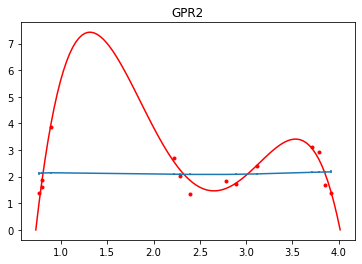

In [18]:
#exponential square kernel
def kernel(x1,x2):
    a = 10
    b = 10
    return a * np.exp(-((x1-x2)*(x1-x2))/b)
X1, X2 = np.meshgrid(xd,xd)
prior_cov = kernel(X1,X2) #np.diag(np.repeat(exp_er,len(x)))#
likelyhood_cov = np.diag(np.repeat(exp_er,len(xd)))
#Now we make the gaussian process distribution for the likelyhood
likelyhood = mnorm(mean=yd, cov=likelyhood_cov)
prior = mnorm(mean=np.repeat(0,len(xd)),cov=prior_cov, allow_singular=True)

#posterior_mean = inv(inv(prior_cov)+inv(likelyhood_cov)) @ (inv(prior_cov)@likelyhood.mean+inv(likelyhood_cov)@prior.mean)
posterior_mean = prior_cov @ inv(prior_cov + likelyhood_cov) @ likelyhood.mean  +  likelyhood_cov @ inv(prior_cov + likelyhood_cov) @ prior.mean
posterior_cov = prior_cov @ inv(prior_cov + likelyhood_cov) @ likelyhood_cov
error_bars2 = np.diagonal(posterior_cov)

print(np.shape(posterior_mean))
figGPR2 = plt.figure()
plt.title('GPR2')
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
# plt.plot(x,posterior_mean,'g')
plt.errorbar(xd,posterior_mean, yerr=error_bars2)
plt.show()